In [1]:
import io
import nbformat
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import re
import csv

In [2]:
data = "train_data.csv"
df1 = pd.read_csv(data)

#Prepare card id and ip id for plotting

# # 1.Card ID
# card_enc = LabelBinarizer()
# df1['card_id'] = card_enc.fit_transform(df1[])

#
# # 2.IP ID
# ip_enc = LabelBinarizer()
# df1['ip_id'] = ip_enc.fit_transform(df1.ip_id)

#Encoding, Cleaning the data
df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

#Feature Engineering
df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

unique_issuer_cc = df1['issuercountrycode'].unique()
unique_shopper_cc = df1['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
lb = LabelBinarizer()
y = lb.fit_transform(df1['issuercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['issuercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('issuercountrycode', axis=1), df2], axis=1)

y = lb.fit_transform(df1['shoppercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['shoppercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shoppercountrycode', axis=1), df2], axis=1)

def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)

lb2 = LabelBinarizer()
y = lb2.fit_transform(df1['txvariantcode'])

# Create a new DataFrame with the transformed 'txvariantcode' column
df2 = pd.DataFrame(y, columns=['txvariantcode_'+str(i) for i in range(y.shape[1])])

# Replace the 'txvariantcode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('txvariantcode', axis=1), df2], axis=1)

lb3 = LabelBinarizer()
y = lb3.fit_transform(df1['currencycode'])

# Create a new DataFrame with the transformed 'currencycode' column
df2 = pd.DataFrame(y, columns=['currencycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'currencycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('currencycode', axis=1), df2], axis=1)

lb4 = LabelBinarizer()
y = lb4.fit_transform(df1['shopperinteraction'])

# Create a new DataFrame with the transformed 'shopperinteraction' column
df2 = pd.DataFrame(y, columns=['shopperinteraction_'+str(i) for i in range(y.shape[1])])

# Replace the 'shopperinteraction' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shopperinteraction', axis=1), df2], axis=1)

df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
df1['accountcode_cc'] = 0
df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

lb5 = LabelBinarizer()
y = lb5.fit_transform(df1['accountcode_cc'])

# Create a new DataFrame with the transformed 'accountcode_cc' column
df2 = pd.DataFrame(y, columns=['accountcode_cc_'+str(i) for i in range(y.shape[1])])

# Replace the 'accountcode_cc' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('accountcode_cc', axis=1), df2], axis=1)

df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

In [3]:
# drop id, mail_id, ip_id, card_id
df1 = df1.drop(['Id','mail_id','ip_id','card_id', 'amount', 'accountcode'], axis=1)

In [5]:
def smote_data(train, test):
    df = train.copy()
    df['label'] = test
    k = 5
    oversampling_ratio = 1
    # classify majority and minority class
    minority_class = df[df['label'] == 1]
    majority_class = df[df['label'] == 0]

    # calculate the difference between the two classes
    nsamples = len(majority_class) - len(minority_class)

    # get samples from the minority class
    samples = minority_class.sample(n=nsamples, replace=True)

    # find k nearest neighbors of each sample in the minority class
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(minority_class)
    distances, indices = nbrs.kneighbors(samples)

    # create synthetic samples
    synthetic_samples = []
    for i in tqdm(range(len(samples))):
        nn = indices[i]
        nn_index = np.random.choice(nn)
        diff = minority_class.iloc[nn_index] - samples.iloc[i]
        r = np.random.rand()
        synthetic_sample = samples.iloc[i] + r * diff
        synthetic_samples.append(synthetic_sample)

    # convert the synthetic samples to a DataFrame
    synthetic_samples = pd.DataFrame(synthetic_samples, columns=df.columns)

    # add the synthetic samples to the minority class
    oversampled = pd.concat([minority_class, synthetic_samples])

    # apply oversampling ratio
    oversampled = oversampled.sample(frac=oversampling_ratio, replace=True)

    # combine with majority class
    smoted = pd.concat([majority_class, oversampled])

    return smoted


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df1.drop('label', axis=1), df1['label'], test_size=0.2, random_state=42)
print(len(X_train))
print(len(y_train))

#combine X_train and y_train
# X_train['label'] = y_train
# print(y_train.columns)
smoted = smote_data(X_train, y_train)
# print column names of X_train
# print(X_train.columns)

# split X_train and y_train from smoted
X_train = smoted.drop('label', axis=1)
y_train = smoted['label']

151702
151702


100%|██████████| 151278/151278 [01:17<00:00, 1943.99it/s]


In [64]:
# Separate features and labels
X = df1.drop('label', axis=1)
y = df1['label']

# Define the number of folds
n_splits = 10

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize accuracy lists to store accuracy for each fold for each classifier
accuracy_list_decision_tree = []
accuracy_list_mlp = []
accuracy_list_logistic= []

y_predicts_all_dec_tree = []
y_truth_all_dec_tree = []
y_proba_all_dec_tree = []

y_predicts_all_mlp = []
y_truth_all_mlp = []
y_proba_all_mlp = []

y_predicts_all_logistic = []
y_truth_all_logistic = []
y_proba_all_logistic = []


round_counter = 0
# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    print('round ', round_counter, ' of ', n_splits)
    round_counter += 1
    # Split the data into training and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_dec_tree.extend(y_proba)
    y_predicts_all_dec_tree.extend(y_pred)
    y_truth_all_dec_tree.extend(y_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_decision_tree.append(accuracy)

    # use a neural network for classification
    # Create and train the Multi-Layer Perceptron Classifier
    clf = MLPClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_mlp.extend(y_proba)
    y_predicts_all_mlp.extend(y_pred)
    y_truth_all_mlp.extend(y_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_mlp.append(accuracy)

    # use logistic regression for classification
    # Create and train the Multi-Layer Perceptron Classifier
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_logistic.extend(y_proba)
    y_predicts_all_logistic.extend(y_pred)
    y_truth_all_logistic.extend(y_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_logistic.append(accuracy)

# Calculate the average accuracy across all folds for decision tree
average_accuracy = np.mean(accuracy_list_decision_tree)
print("Average accuracy decision tree:", average_accuracy)

# Calculate the average accuracy across all folds for MLP
average_accuracy = np.mean(accuracy_list_mlp)
print("Average accuracy mlp:", average_accuracy)

# Calculate the average accuracy across all folds for logistic regression
average_accuracy = np.mean(accuracy_list_logistic)
print("Average accuracy logistic regression:", average_accuracy)

round  0  of  3
round  1  of  3
round  2  of  3
Average accuracy decision tree: 0.9976480272744067
Average accuracy mlp: 0.9985445187418769
Average accuracy logistic regression: 0.9985339717206193


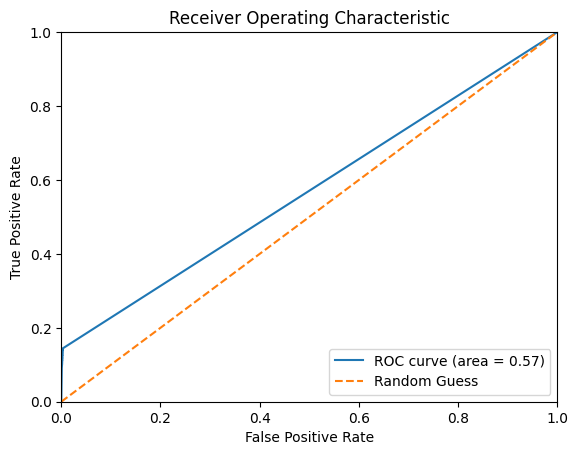

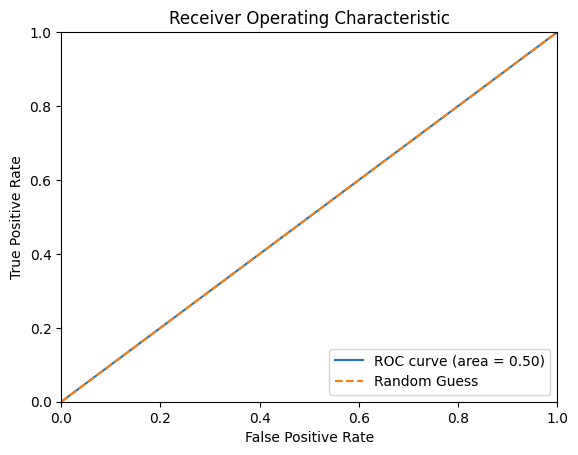

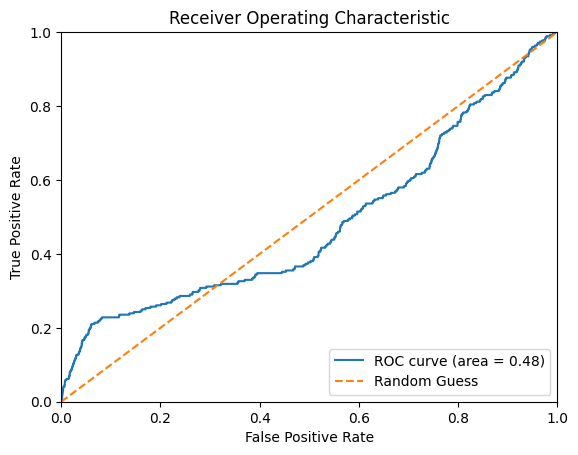

In [66]:
one_prob_dec_tree = [lst[1] for lst in y_proba_all_dec_tree]
fpr, tpr, thresholds = roc_curve(y_truth_all_dec_tree, one_prob_dec_tree)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

one_prob_mlp = [lst[1] for lst in y_proba_all_mlp]
fpr, tpr, thresholds = roc_curve(y_truth_all_mlp, one_prob_mlp)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

one_prob_logistic = [lst[1] for lst in y_proba_all_logistic]
fpr, tpr, thresholds = roc_curve(y_truth_all_logistic, one_prob_logistic)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [8]:
# Separate features and labels
X = df1.drop('label', axis=1)
y = df1['label']

# Define the number of folds
n_splits = 10

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize accuracy lists to store accuracy for each fold for each classifier
accuracy_list_decision_tree = []
accuracy_list_mlp = []
accuracy_list_logistic= []

y_predicts_all_dec_tree = []
y_truth_all_dec_tree = []
y_proba_all_dec_tree = []

y_predicts_all_mlp = []
y_truth_all_mlp = []
y_proba_all_mlp = []

y_predicts_all_logistic = []
y_truth_all_logistic = []
y_proba_all_logistic = []


round_counter = 0
# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    print('round ', round_counter, ' of ', n_splits)
    round_counter += 1
    # Split the data into training and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    smoted = smote_data(X_train,y_train)

    # split the smoted into x and y
    X_train = smoted.drop('label', axis=1)
    y_train = smoted['label']


    # Create and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_dec_tree.extend(y_proba)
    y_predicts_all_dec_tree.extend(y_pred)
    y_truth_all_dec_tree.extend(y_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_decision_tree.append(accuracy)

    # use a neural network for classification
    # Create and train the Multi-Layer Perceptron Classifier
    clf = MLPClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_mlp.extend(y_proba)
    y_predicts_all_mlp.extend(y_pred)
    y_truth_all_mlp.extend(y_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_mlp.append(accuracy)

    # use logistic regression for classification
    # Create and train the Multi-Layer Perceptron Classifier
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_logistic.extend(y_proba)
    y_predicts_all_logistic.extend(y_pred)
    y_truth_all_logistic.extend(y_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_logistic.append(accuracy)

# Calculate the average accuracy across all folds for decision tree
average_accuracy = np.mean(accuracy_list_decision_tree)
print("Average accuracy decision tree:", average_accuracy)

# Calculate the average accuracy across all folds for MLP
average_accuracy = np.mean(accuracy_list_mlp)
print("Average accuracy mlp:", average_accuracy)

# Calculate the average accuracy across all folds for logistic regression
average_accuracy = np.mean(accuracy_list_logistic)
print("Average accuracy logistic regression:", average_accuracy)

round  0  of  3


100%|██████████| 126050/126050 [01:05<00:00, 1924.87it/s]


round  1  of  3


100%|██████████| 126051/126051 [01:05<00:00, 1912.52it/s]


round  2  of  3


100%|██████████| 126051/126051 [01:05<00:00, 1924.99it/s]


Average accuracy decision tree: 0.9890997127645322
Average accuracy logistic regression: 0.7994020949379298


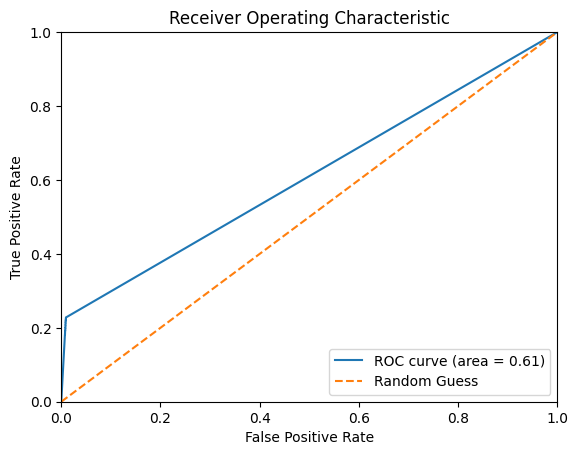

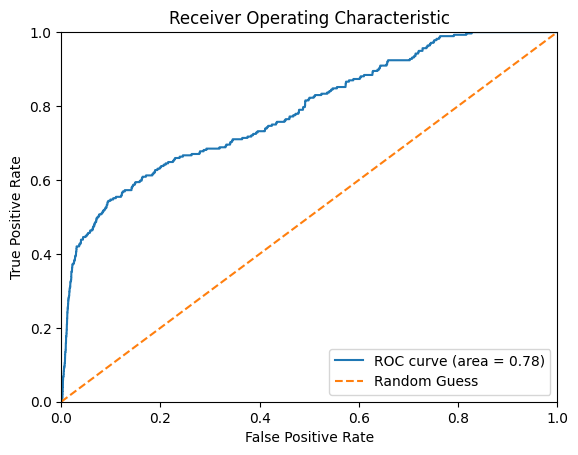

In [9]:
one_prob_dec_tree = [lst[1] for lst in y_proba_all_dec_tree]
fpr, tpr, thresholds = roc_curve(y_truth_all_dec_tree, one_prob_dec_tree)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# one_prob_mlp = [lst[1] for lst in y_proba_all_mlp]
# fpr, tpr, thresholds = roc_curve(y_truth_all_mlp, one_prob_mlp)
# roc_auc = auc(fpr, tpr)

# plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

one_prob_logistic = [lst[1] for lst in y_proba_all_logistic]
fpr, tpr, thresholds = roc_curve(y_truth_all_logistic, one_prob_logistic)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [55]:
# Separate features and labels
X = df1.drop('label', axis=1)
y = df1['label']

# Define the number of folds
n_splits = 3

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize accuracy lists to store accuracy for each fold for each classifier
accuracy_list_decision_tree = []
accuracy_list_mlp = []
accuracy_list_logistic = []

roc_list_decision = []
roc_list_mlp = []
roc_list_logistic = []


# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    print(train_index)
    print(len(train_index))
    # Split the data into training and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred_decision = clf.predict(X_test)
    y_pred_decision_prob = clf.predict_proba(X_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred_decision)
    accuracy_list_decision_tree.append(accuracy)
    # calculate the tpr and fpr and add it to the roc_list
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_decision_prob[:,1])
    roc_list_decision.append((fpr, tpr))

    # use a neural network for classification
    # Create and train the Multi-Layer Perceptron Classifier
    clf = MLPClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred_mlp = clf.predict(X_test)
    y_pred_mlp_prob = clf.predict_proba(X_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred_mlp)
    accuracy_list_mlp.append(accuracy)
    # calculate the tpr and fpr and add it to the roc_list
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_mlp_prob[:,1])
    roc_list_mlp.append((fpr, tpr))

    #create and train logistic regression
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred_logistic = clf.predict(X_test)
    y_pred_logistic_prob = clf.predict_proba(X_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred_logistic)
    accuracy_list_logistic.append(accuracy)
    # calculate the tpr and fpr and add it to the roc_list
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_logistic_prob[:,1])
    roc_list_logistic.append((fpr, tpr))

# Calculate the average accuracy across all folds for decision tree
average_accuracy = np.mean(accuracy_list_decision_tree)
print("Average accuracy decision tree:", average_accuracy)

# Calculate the average accuracy across all folds for MLP
average_accuracy = np.mean(accuracy_list_mlp)
print("Average accuracy MLP:", average_accuracy)

# Calculate the average accuracy across all folds for logistic regression
average_accuracy = np.mean(accuracy_list_logistic)
print("Average accuracy logistic regression:", average_accuracy)


[     2      3      5 ... 189625 189626 189627]
126418
[     0      1      4 ... 189621 189625 189626]
126419
[     0      1      2 ... 189623 189624 189627]
126419
Average accuracy decision tree: 0.9976480272744067
Average accuracy MLP: 0.9985445187418769
Average accuracy logistic regression: 0.9985339717206193


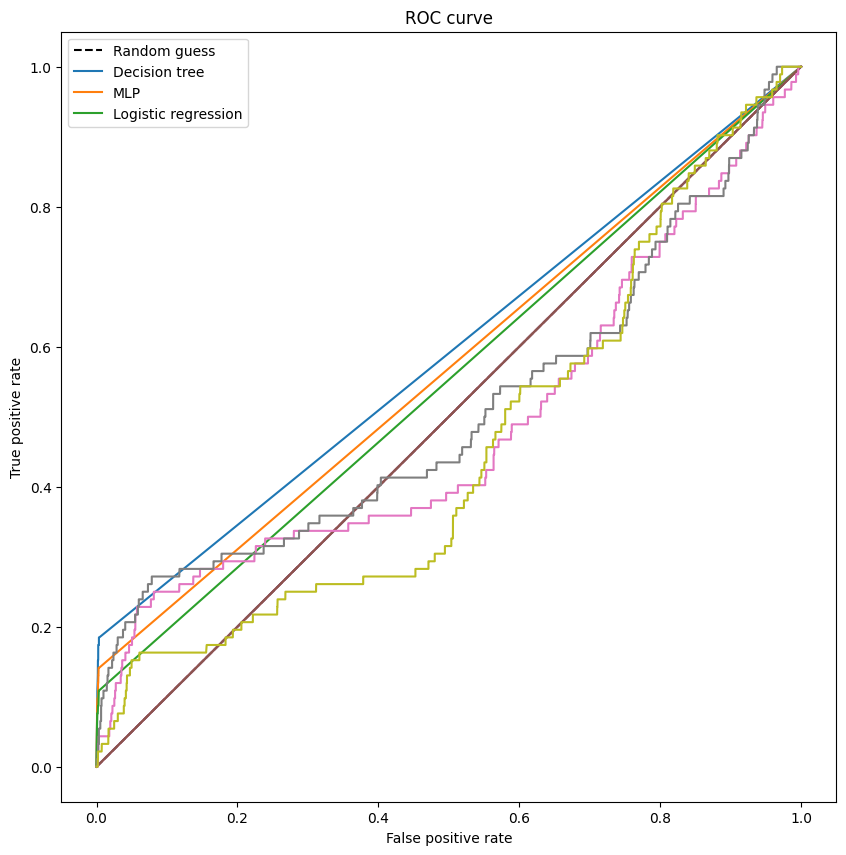

In [56]:
# Plot the ROC curves for all classifiers
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
for fpr, tpr in roc_list_decision:
    plt.plot(fpr, tpr)
for fpr, tpr in roc_list_mlp:
    plt.plot(fpr, tpr)
for fpr, tpr in roc_list_logistic:
    plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(['Random guess', 'Decision tree', 'MLP', 'Logistic regression'])
plt.show()

In [50]:
# # split the smoted data into train and test sets
# X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(smoted, smoted['label'], test_size=0.2, random_state=42)
# X_train_unsmoted, X_test_unsmoted, y_train_unsmoted, y_test_unsmoted = train_test_split(df1, df1['label'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df1, df1['label'], test_size=0.2, random_state=42)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(smoted, smoted['label'], test_size=0.2, random_state=42)

1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37862
           1       1.00      1.00      1.00        64

    accuracy                           1.00     37926
   macro avg       1.00      1.00      1.00     37926
weighted avg       1.00      1.00      1.00     37926



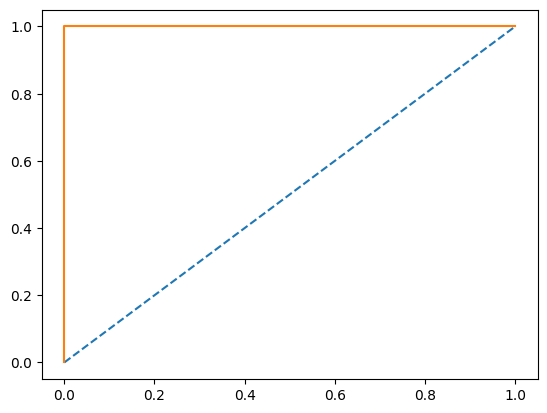

In [52]:
# draw roc curve for decision tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_decision = clf.predict(X_test)
print(accuracy_score(y_test, y_pred_decision))
print(classification_report(y_test, y_pred_decision))

y_pred_decision_prob = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_decision_prob[:,1])



# plot ROC curve of decision tree
auc = roc_auc_score(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, label='Decision Tree (area = {:.3f})'.format(auc))


0.9982597690238886
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37862
           1       0.00      0.00      0.00        64

    accuracy                           1.00     37926
   macro avg       0.50      0.50      0.50     37926
weighted avg       1.00      1.00      1.00     37926



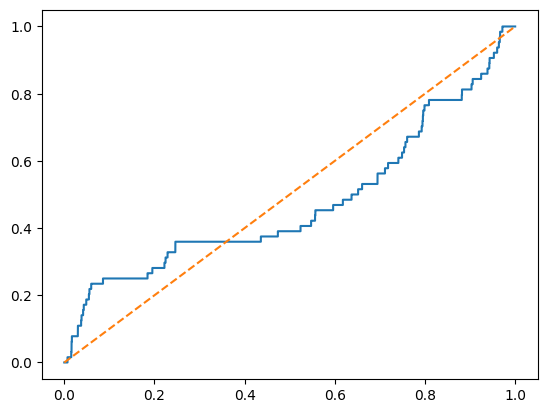

In [49]:
# draw ROC curve for logistic regression
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
y_pred_logistic = clf.predict(X_test)
y_pred_logistic_prob = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logistic_prob[:,1])

print(accuracy_score(y_test, y_pred_logistic))
print(classification_report(y_test, y_pred_logistic))

# plot ROC curve of logistic regression
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--')


In [30]:
# Create and train the Multi-Layer Perceptron Classifier
clf = MLPClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Print the classification report and accuracy
print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37862
           1       0.00      0.00      0.00        64

    accuracy                           1.00     37926
   macro avg       0.50      0.50      0.50     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 0.998312503295892


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


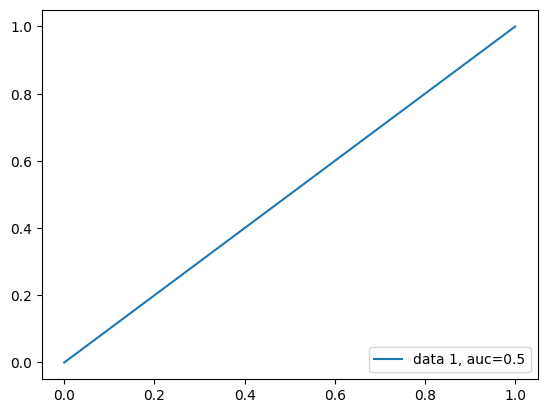

In [32]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [33]:
# Separate features and labels
X = df1.drop('label', axis=1)
y = df1['label']

# Define the number of folds
n_splits = 10

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize accuracy lists to store accuracy for each fold for each classifier
accuracy_list_decision_tree = []
accuracy_list_mlp = []
accuracy_list_logistic = []


# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    print(train_index)
    print(len(train_index))
    # Split the data into training and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred_decision = clf.predict(X_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred_decision)
    accuracy_list_decision_tree.append(accuracy)

    # use a neural network for classification
    # Create and train the Multi-Layer Perceptron Classifier
    clf = MLPClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred_mlp = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_mlp)
    accuracy_list_mlp.append(accuracy)

    #create and train logistic regression
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred_logistic = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_logistic)
    accuracy_list_logistic.append(accuracy)

# Calculate the average accuracy across all folds for decision tree
average_accuracy = np.mean(accuracy_list_decision_tree)
print("Average accuracy decision tree:", average_accuracy)

# # Calculate the average accuracy across all folds for MLP
# average_accuracy = np.mean(accuracy_list_mlp)
# print("Average accuracy mlp:", average_accuracy)

# Calculate the average accuracy across all folds for logistic regression
average_accuracy = np.mean(accuracy_list_logistic)
print("Average accuracy logistic regression:", average_accuracy)

[     1      2      3 ... 189625 189626 189627]
170665
[     0      1      2 ... 189625 189626 189627]
170665
[     0      2      3 ... 189625 189626 189627]
170665
[     0      1      4 ... 189625 189626 189627]
170665
[     0      1      2 ... 189625 189626 189627]
170665
[     0      1      2 ... 189625 189626 189627]
170665
[     0      1      2 ... 189622 189624 189626]
170665
[     0      1      2 ... 189624 189625 189627]
170665
[     0      1      2 ... 189625 189626 189627]
170666
[     0      1      2 ... 189625 189626 189627]
170666
Average accuracy decision tree: 0.9976532993101891
Average accuracy logistic regression: 0.9985286982372253


/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


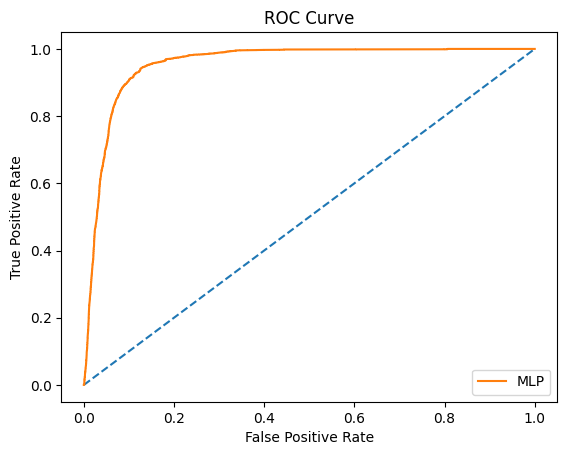

In [28]:
# plot roc curve of mlp
clf = MLPClassifier(random_state=42)
clf.fit(X_train, y_train)
# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr,tpr,label="MLP")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()


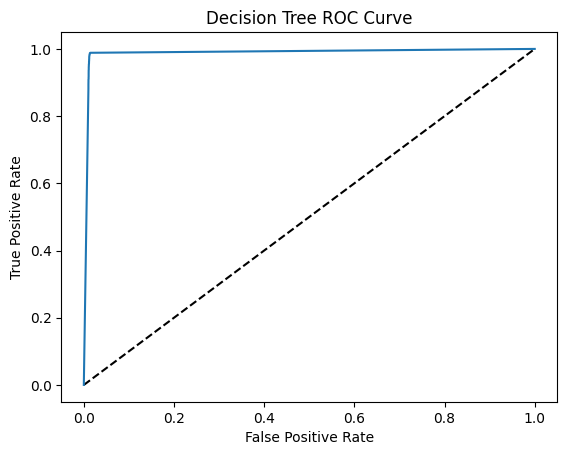

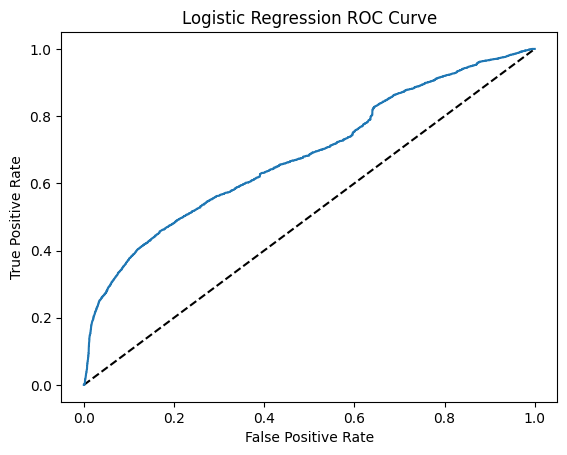

In [27]:
# plot roc curve of decision tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()

# plot roc curve of logistic regression
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [24]:
# Separate features and labels
X = smoted.drop('label', axis=1)
y = smoted['label']

# Define the number of folds
n_splits = 10

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize accuracy lists to store accuracy for each fold for each classifier
accuracy_list_decision_tree_smote = []
accuracy_list_logistic_smote = []


# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    print(train_index)
    # Split the data into training and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_decision_tree_smote.append(accuracy)
    print("done decision tree")

    #create and train logistic regression
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_logistic_smote.append(accuracy)
    print("done logistic")

# Calculate the average accuracy across all folds for decision tree
average_accuracy = np.mean(accuracy_list_decision_tree_smote)
print("Average accuracy decision tree:", average_accuracy)

# Calculate the average accuracy across all folds for logistic regression
average_accuracy = np.mean(accuracy_list_logistic_smote)
print("Average accuracy logistic regression:", average_accuracy)

[     1      2      3 ... 378701 378702 378703]
done decision tree
done logistic
[     0      1      2 ... 378701 378702 378703]
done decision tree
done logistic
[     0      2      3 ... 378701 378702 378703]
done decision tree
done logistic
[     0      1      4 ... 378701 378702 378703]
done decision tree
done logistic
[     0      1      2 ... 378701 378702 378703]
done decision tree
done logistic
[     0      1      2 ... 378701 378702 378703]
done decision tree
done logistic
[     0      1      2 ... 378698 378700 378702]
done decision tree
done logistic
[     0      1      2 ... 378700 378701 378703]
done decision tree
done logistic
[     0      1      2 ... 378701 378702 378703]
done decision tree
done logistic
[     0      1      2 ... 378701 378702 378703]
done decision tree
done logistic
Average accuracy decision tree: 0.9878189839443348
Average accuracy logistic regression: 0.6423143128504485


In [22]:
print(accuracy_list_decision_tree)
print(accuracy_list_logistic)

[0.987853502680151, 0.9877478809643263, 0.9879591243959758, 0.9872197723852024, 0.9877211513071033, 0.988539741219963, 0.9882492738315289, 0.9880644309479799, 0.9875891206759968, 0.9872458410351201]
[0.6428929787964406, 0.643368276517652, 0.641863167067149, 0.6415991127775871, 0.6457882228677053, 0.6407974650118827, 0.6424346448376024, 0.6391602851861632, 0.6447319778188539, 0.6405069976234486]


In [ ]:
# Separate features and labels
X = smoted.drop('label', axis=1)
y = smoted['label']

# Define the number of folds
n_splits = 10

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize accuracy lists to store accuracy for each fold for each classifier
accuracy_list_mlp_smote = []


# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    print(train_index)
    # Split the data into training and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # use a neural network for classification
    # Create and train the Multi-Layer Perceptron Classifier
    clf = MLPClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_mlp_smote.append(accuracy)
    print("done mlp")

# Calculate the average accuracy across all folds for MLP
average_accuracy = np.mean(accuracy_list_mlp_smote)
print("Average accuracy mlp:", average_accuracy)
